In [1]:
%matplotlib widget
import matplotlib.pylab as plt
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from astroML.plotting.tools import draw_ellipse
import math

/Users/cabrera-ziri/anaconda3/lib/python3.11/site-packages/astroML/linear_model/linear_regression_errors.py:10: UserWarning: LinearRegressionwithErrors requires PyMC3 to be installed
  warnings.warn('LinearRegressionwithErrors requires PyMC3 to be installed')


# Figure formatting


In [2]:
# extra code – the next 5 lines define the default font sizes
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)


# Load data


In [3]:
df = pd.read_csv('data/m4_gaia.csv')

#keep only relevant columns
df = df[['index','x','y','r','phot_g_mean_mag','bp_rp','member']]

df = df.dropna() #drop missing values
df = df.set_index('index')
df = df.reset_index()

#rename columns
df.rename(columns = {'phot_g_mean_mag':'magnitude','bp_rp':'color'}, inplace = True) 

## split cluster and field sample based on positions

In [4]:
cluster_sample_radius = 0.5
field_sample_radius = 3

cluster = df[df['r']<=cluster_sample_radius]
field = df[df['r']>=field_sample_radius]

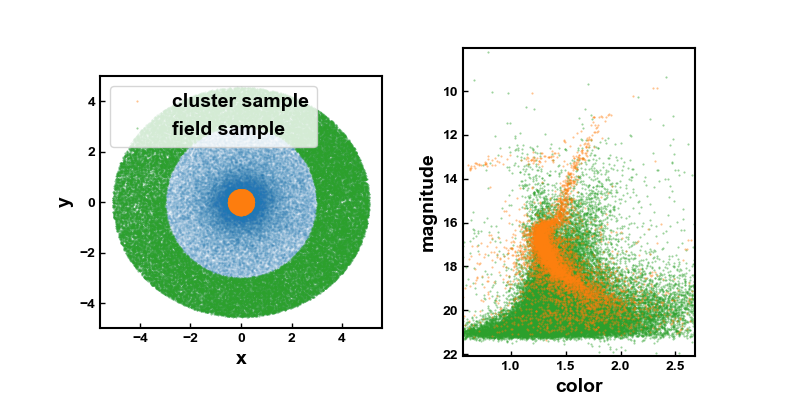

No such comm: 8ec9585d4a11480a8789bb6b5f6c9c53


In [185]:
nrows = 1
ncols = 2
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, layout=None,figsize=(8,4))

alpha1 = 0.1
alpha2 = 0.5
cmd_aspect = 0.2

ax[0].plot(df['x'],df['y'],'.',alpha=alpha1,ms=1,label='')
ax[0].plot(cluster['x'],cluster['y'],'.',alpha=alpha2,ms=1,label='cluster sample')
ax[0].plot(field['x'],field['y'],'.',alpha=alpha2,ms=1,label='field sample')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[0].set_aspect(1)
ax[0].legend()

ax[1].plot(field['color'],field['magnitude'],'.',alpha=alpha2,ms=1,label='field sample',color='tab:green')
ax[1].plot(cluster['color'],cluster['magnitude'],'.',alpha=alpha2,ms=1,label='cluster sample',color='tab:orange')
ax[1].set_xlabel('color')
ax[1].set_ylabel('magnitude')
ax[1].set_xlim(np.percentile(df['color'],[1,99])) 
ax[1].set_ylim(df['magnitude'].max(),df['magnitude'].min()) 
ax[1].set_aspect(cmd_aspect)

In [186]:
plt.savefig('figures/starting_samples.png',bbox_inches='tight',dpi=150)
plt.close('all')

# Model CMDs


In [7]:
from sklearn.mixture import GaussianMixture

def compute_GaussianMixture(N, covariance_type='full', max_iter=1000):
    models = [None for n in N]
    for i in range(len(N)):
        models[i] = GaussianMixture(n_components=N[i], max_iter=max_iter,
                                    covariance_type=covariance_type,random_state=42)
        models[i].fit(X)
    return models

def plot_density_figure(ax, data, text,color_bins,magnitude_bins):
    ax.imshow(data,
              origin='lower', interpolation='nearest', aspect='auto',
              extent=[color_bins[0], color_bins[-1],
                      magnitude_bins[0], magnitude_bins[-1]],
              cmap=plt.cm.viridis)
    return ax

def GMM_CMD(X,N):
    models = compute_GaussianMixture(N)

    AIC = [m.aic(X) for m in models]
    BIC = [m.bic(X) for m in models]

    i_best = np.argmin(BIC)
    gmm_best = models[i_best]
    print("best fit converged:", gmm_best.converged_)
    print("BIC: n_components =  %i" % N[i_best])

    # GMM model plot
    fig = plt.figure(figsize=(3,3))
    ax = fig.add_subplot(111)
    ax.plot(N, AIC, '-k', label='AIC')
    ax.plot(N, BIC, ':k', label='BIC')
    ax.legend(loc=1)
    ax.set_xlabel('N components')
    fig.tight_layout()
    plt.setp(ax.get_yticklabels(), fontsize=7)

    # real vs. mock CMD
    mock_phot,_labels = gmm_best.sample(n_samples=X.shape[0])

    nrows = 2
    ncols = 2
    
    fig2, ax = plt.subplots(nrows=nrows, ncols=ncols, layout=None,figsize=(8,8),sharex=True,sharey=True)

    alpha2 = 0.5
    cmd_aspect = 0.2

    ax[0,0].plot(X[:,0],X[:,1],'.',alpha=alpha2,ms=1,label='real sample',color='tab:blue')
    ax[0,1].plot(mock_phot[:,0],mock_phot[:,1],'.',alpha=alpha2,ms=1,label='mock sample',color='tab:blue')

    ax[0,0].set_title('real sample')
    ax[0,1].set_title('mock sample')

    # Density plots

    color_bins_number = 51*2
    magnitude_bins_number = 51
    H, color_bins, magnitude_bins = np.histogram2d(X[:,0],X[:,1] ,
                                            (color_bins_number, magnitude_bins_number))

    Xgrid = np.array(list(map(np.ravel,
                            np.meshgrid(0.5 * (color_bins[:-1]
                                                + color_bins[1:]),
                                        0.5 * (magnitude_bins[:-1]
                                                + magnitude_bins[1:]))))).T
    log_dens = gmm_best.score_samples(Xgrid).reshape((magnitude_bins_number,color_bins_number))

    plot_density_figure(ax[1,0], H.T, "real sample",color_bins,magnitude_bins)
    plot_density_figure(ax[1,1], np.exp(log_dens), "Converged",color_bins,magnitude_bins)

    ax[1,1].scatter(gmm_best.means_[:, 0], gmm_best.means_[:, 1], c='w',s=1)
    for mu, C, w in zip(gmm_best.means_, gmm_best.covariances_, gmm_best.weights_):
        draw_ellipse(mu, C, scales=[1.5], ax=ax[1,1], fc='none', ec='grey',lw=.5)

    for _ax in ax.ravel():
        _ax.grid()
        # _ax.legend()
        _ax.set_xlabel('color')
        _ax.set_ylabel('magnitude')
        _ax.set_xlim(np.percentile(X[:,0],[1,99])) 
        _ax.set_ylim(X[:,1].max(),X[:,1].min()) 
        _ax.set_aspect(cmd_aspect)
    
    fig2.tight_layout()
    
    return gmm_best

## Cluster GMM

best fit converged: True
BIC: n_components =  15


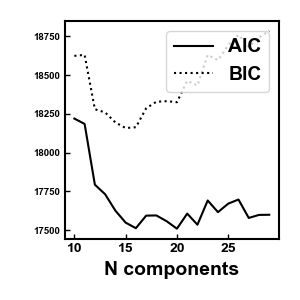

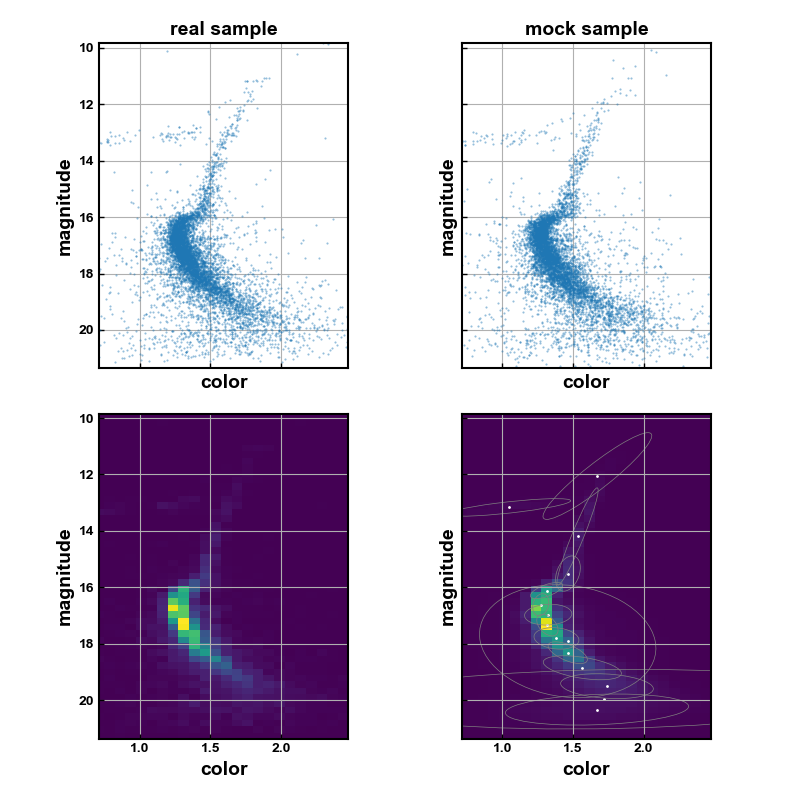

In [8]:
X = np.vstack([cluster['color'], cluster['magnitude']]).T
ngauss = np.arange(10, 30,1)

plt.close('all')
cluster_gmm = GMM_CMD(X,ngauss)
plt.savefig('figures/mock_cluster_cmd.png',bbox_inches='tight',dpi=150)

## Field GMM

best fit converged: True
BIC: n_components =  21


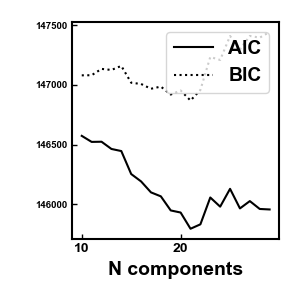

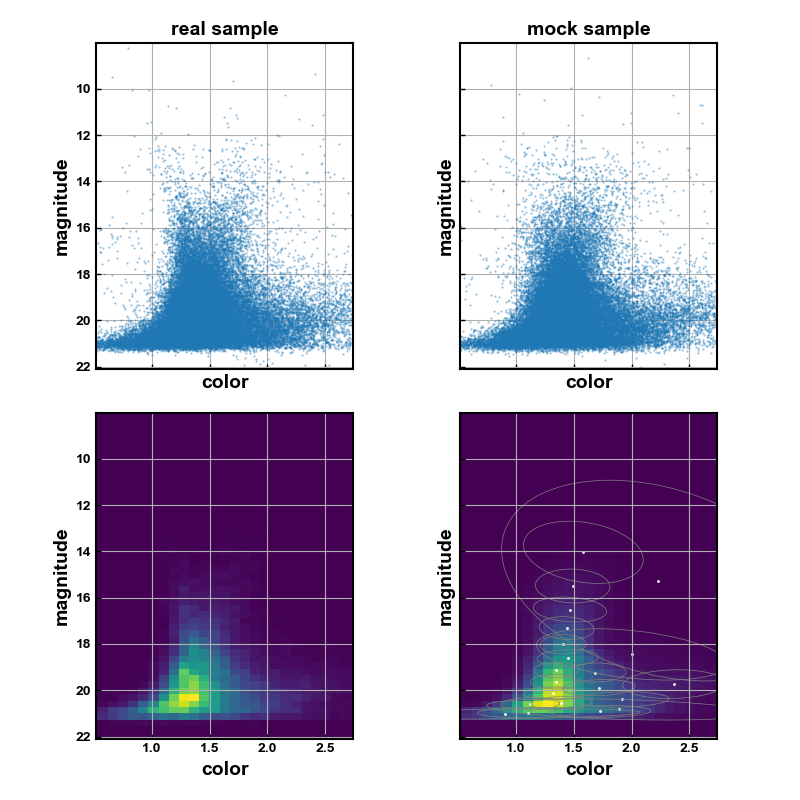

In [9]:
X = np.vstack([field['color'], field['magnitude']]).T
ngauss = np.arange(10, 30,1)

plt.close('all')
field_gmm = GMM_CMD(X,ngauss)
plt.savefig('figures/mock_field_cmd.png',bbox_inches='tight',dpi=150)

In [10]:
plt.close('all')

# Model positions

## Cluster positions
Here I'm going to repeat the same pre-processing I carried out on the real cluster data

In [11]:
# real cluster data
gc_data = pd.read_fwf('data/baumgardt_table.dat')

cluster_mask = gc_data['Cluster'] == 'NGC_6121'

# centre
# ra = gc_data.loc[cluster_mask]['RA'].to_numpy()
# dec = gc_data.loc[cluster_mask]['DEC'].to_numpy()

# rhm in degrees
dist = gc_data.loc[cluster_mask]['R_Sun'].to_numpy()*1e3 #distance in pc
rhm = gc_data.loc[cluster_mask]['rhm'].to_numpy() #r_hm in pc
rhm_deg = math.degrees(math.atan(rhm/dist))


### Plummer model distribution


In [12]:
def plummer_xy(rhm_deg,N):
    a = rhm_deg/1.3 # https://en.wikipedia.org/wiki/Plummer_model

    #azimutal angle
    phi = np.random.uniform(0, 2*np.pi,N)
    #polar angle
    theta = np.arccos( np.random.uniform(-1,1,N) )
    #radius
    r = a / np.sqrt( np.random.uniform(0, 1,N)**(-2.0 / 3.0) - 1)

    ra_list = r*np.sin(theta)*np.cos(phi)
    dec_list = r*np.sin(theta)*np.sin(phi)

    #return ra and dec normalised in rhm units centred in cluster
    x = ra_list/rhm_deg
    y = dec_list/rhm_deg
    return x,y

In [136]:
scale_factor = 2 # should be in int or breaks plot below
N_cluster = df['member'].sum()*scale_factor # number of cluster stars to simulate (real cluster stars x scale factor)

x,y = plummer_xy(rhm_deg,N_cluster)

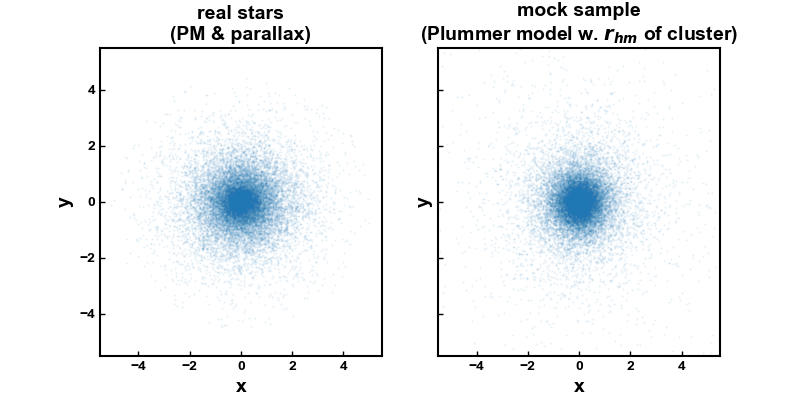

In [137]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(8,4),sharex=True,sharey=True)

ax[0].plot(df['x'][df['member']==1],df['y'][df['member']==1],'.',ms=1,alpha=0.1)
ax[1].plot(x[::scale_factor],y[::scale_factor],'.',ms=1,alpha=0.1)
ax[0].set_title('real stars\n(PM & parallax)')
ax[1].set_title('mock sample\n(Plummer model w. $r_{hm}$ of cluster)')
for _ax in ax.ravel():
    _ax.set_xlim(-5.5,5.5)
    _ax.set_ylim(-5.5,5.5)
    _ax.set_xlabel('x')
    _ax.set_ylabel('y')

In [138]:
plt.close('all')

In [139]:
# mock cluster catalogue
mock_phot,_labels = cluster_gmm.sample(N_cluster)

mock_cluster = {'x':x,'y':y,'r':np.sqrt(x**2+y**2),'magnitude': mock_phot[:,1],'color':mock_phot[:,0],'member':np.ones(N_cluster,dtype=int)}
mock_cluster = pd.DataFrame(data=mock_cluster)
del(_labels,mock_phot)

## Field positoins

In [140]:
def uniform_xy(box_width,N_field):
    x = np.random.uniform(-box_width/2,box_width/2,N_field)
    y = np.random.uniform(-box_width/2,box_width/2,N_field)
    return x,y

In [141]:
density = np.sum(df['member']==0)/(np.pi*(df['r'].max())**2) #no. field stars / area
box_width = df['r'].max()*2 # size of box to be filled with field stars

N_field = int(np.round(density*box_width*box_width))*scale_factor

x,y = uniform_xy(box_width,N_field)

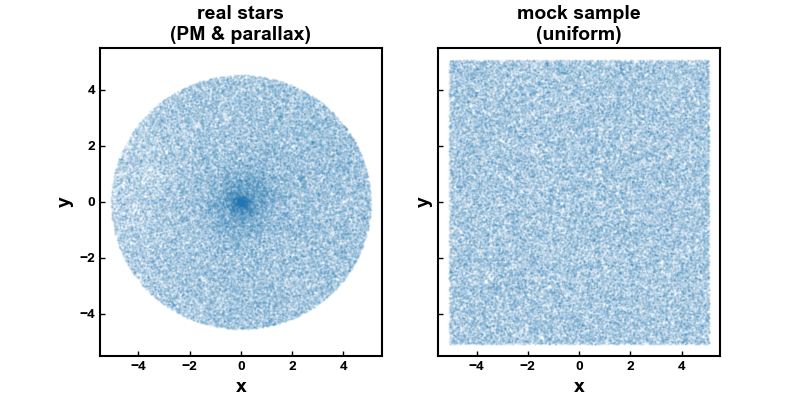

No such comm: a25f8ca1fa8b480ab022e57f9fcfad98


In [142]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(8,4),sharex=True,sharey=True)

ax[0].plot(df['x'][df['member']==0],df['y'][df['member']==0],'.',ms=1,alpha=0.1)
ax[1].plot(x[::scale_factor],y[::scale_factor],'.',ms=1,alpha=0.1)
ax[0].set_title('real stars\n(PM & parallax)')
ax[1].set_title('mock sample\n(uniform)')
for _ax in ax.ravel():
    _ax.set_xlim(-5.5,5.5)
    _ax.set_ylim(-5.5,5.5)
    _ax.set_xlabel('x')
    _ax.set_ylabel('y')

In [143]:
plt.close('all')

In [144]:
# field cluster catalogue
mock_phot,_labels = field_gmm.sample(N_field)

mock_field = {'x':x,'y':y,'r':np.sqrt(x**2+y**2),'magnitude': mock_phot[:,1],'color':mock_phot[:,0],'member':np.zeros(N_field,dtype=int)}
mock_field = pd.DataFrame(data=mock_field)
del(_labels,mock_phot)

In [145]:
mock_data = pd.concat([mock_cluster, mock_field])
del(mock_cluster, mock_field)

#trimming data to fit observed FoV is important!
mock_data = mock_data[mock_data['r'].to_numpy()<=df['r'].max()]

mock_data = mock_data.reset_index()
mock_data.set_index('index')

x         y         r  magnitude     color  member
index                                                            
0       0.369227 -0.530875  0.646651  15.285282  1.481149       1
1       1.802083  0.158989  1.809083  15.033086  1.507742       1
2      -0.452059 -0.214914  0.500545  15.260777  1.460054       1
3      -0.300909  0.103117  0.318087  15.265938  1.578331       1
4      -1.089006 -0.269160  1.121776  15.503546  1.406198       1
...          ...       ...       ...        ...       ...     ...
180719  2.718081  0.754961  2.820980  20.352137  1.360993       0
180720  3.157062  1.981749  3.727516  20.561149  1.178657       0
180721 -1.625223  1.943473  2.533463  20.842141  1.230751       0
180722  2.644851  0.193918  2.651950  20.582500  1.060362       0
180723 -0.165043 -3.249145  3.253334  20.692027  0.732331       0

[179007 rows x 6 columns]

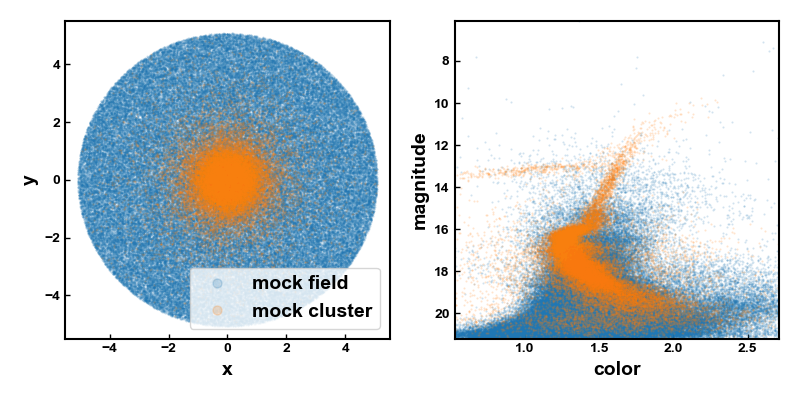

No such comm: 635db47845bc40b6b58e3c2a7149c0d1


In [183]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(8,4))

kwargs = {'ms':1, 'alpha':0.2}

ax[0].plot(mock_data['x'][mock_data['member']==0],mock_data['y'][mock_data['member']==0],'.',label='mock field',**kwargs)
ax[0].plot(mock_data['x'][mock_data['member']==1],mock_data['y'][mock_data['member']==1],'.',label='mock cluster',**kwargs)

ax[1].plot(mock_data['color'][mock_data['member']==0],mock_data['magnitude'][mock_data['member']==0],'.',label='mock field',**kwargs)
ax[1].plot(mock_data['color'][mock_data['member']==1],mock_data['magnitude'][mock_data['member']==1],'.',label='mock cluster',**kwargs)

ax[0].legend(markerscale=13)
ax[0].set_xlim(-5.5,5.5)
ax[0].set_ylim(-5.5,5.5)
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')

ax[1].set_xlim(np.percentile(mock_data['color'],[1,99])) 
ax[1].set_ylim(np.percentile(mock_data['magnitude'],[99,0.0])) 
# ax[1].set_ylim(mock_data['magnitude'].max(),mock_data['magnitude'].min()) 
ax[1].set_xlabel('color')
ax[1].set_ylabel('magnitude')
plt.tight_layout()

In [184]:
plt.savefig('figures/mock_data.png',bbox_inches='tight',dpi=150)
plt.close('all')

# Split train/test sets

In [148]:
#stratified split between member and field stars
split = StratifiedShuffleSplit(n_splits=1,test_size=0.1,random_state=42)

for train_index, test_index in split.split(mock_data,mock_data['member']):
    strat_train_set = mock_data.loc[train_index]
    strat_test_set = mock_data.loc[test_index]

#set index
strat_train_set = strat_train_set.set_index("index")
strat_test_set = strat_test_set.set_index("index")

train_member_labels = strat_train_set["member"].copy()
test_member_labels = strat_test_set["member"].copy()

strat_train_set['member'].value_counts()/len(strat_train_set)

member
0    0.793279
1    0.206721
Name: count, dtype: float64

# Preprocess pipeline (mock data)

In [149]:
num_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", RobustScaler())
    ])

cat_pipeline = Pipeline([
        ("ordinal_encoder", OrdinalEncoder()),    
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("cat_encoder", OneHotEncoder(sparse_output=False)),
    ])

# join numerical and categorical pipelines

num_attribs = ["x", "y", "r", "magnitude","color"]
cat_attribs = ["member"]

# preprocess_pipeline = ColumnTransformer([
#         ("num", num_pipeline, num_attribs),
#         ("cat", cat_pipeline, cat_attribs),
#     ])

preprocess_pipeline = ColumnTransformer([
         ("num", num_pipeline, num_attribs)])

In [150]:
X_train = preprocess_pipeline.fit_transform(strat_train_set.drop('member',axis=1))
y_train = train_member_labels

X_test = preprocess_pipeline.fit_transform(strat_test_set.drop('member',axis=1))
y_test = test_member_labels

# Training

In [151]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score,cross_val_predict

In [152]:
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [93]:
#this takes a lot of time so you can skip it if it's working
# forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
# forest_scores.mean()

0.9426198171850297

In [153]:
#feature importances
sorted(zip(forest_clf.feature_importances_,
           strat_train_set.columns[:-1]),
           reverse=True)

[(0.4755008039031625, 'r'),
 (0.23263894585017536, 'magnitude'),
 (0.10311666800822349, 'color'),
 (0.09770714575170651, 'y'),
 (0.09103643648673196, 'x')]

In [154]:
y_train_pred = cross_val_predict(forest_clf,X_train,y_train,cv=3)

## Metrics

In [96]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

In [ ]:
#perfect lables do not touch
confusion_matrix(y_train,y_train_pred)

array([[60406,  3467],
       [ 3786, 13250]])

In [155]:
confusion_matrix(y_train,y_train_pred)

array([[123449,   4353],
       [  6571,  26733]])

In [156]:
precision_score(y_train, y_train_pred)

0.8599691179309014

In [157]:
recall_score(y_train, y_train_pred)

0.8026963728080712

In [158]:
f1_score(y_train, y_train_pred)

0.8303463270694207

# Predict on test set

In [159]:
y_pred = forest_clf.predict(X_test)

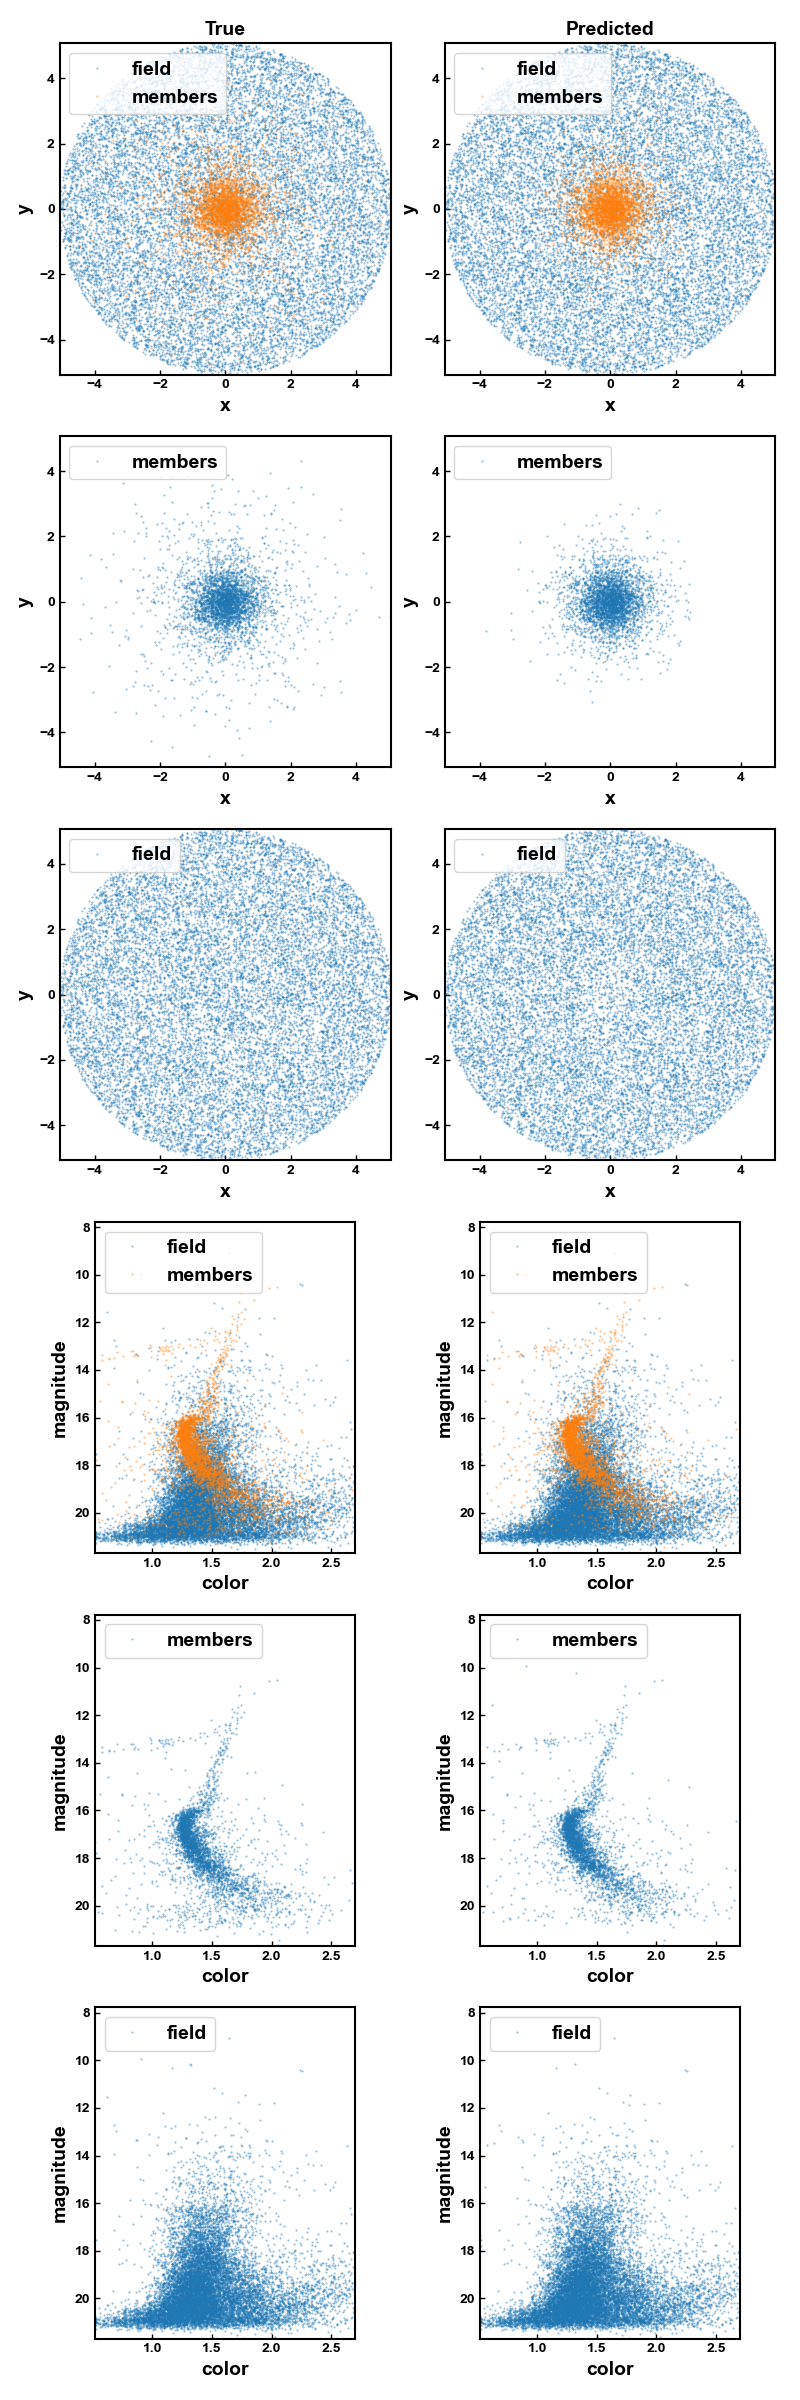

In [160]:
plt.close('all')
def myplot(row_number,set,xname,yname,pop,cmd=False,labels=True):
    if pop=='members':
        _pop=1
    elif pop=='field':
        _pop=0
    else:
        print("pop must be 'members' or 'field'")
    if labels:
        pass
    else:
        pop=''
    ax[row_number,0].plot(set[xname][y_test==_pop],set[yname][y_test==_pop],'.',alpha=0.5,ms=1,label=pop)
    ax[row_number,1].plot(set[xname][y_pred==_pop],set[yname][y_pred==_pop],'.',alpha=0.5,ms=1,label=pop)
    # ax[row_number,1].plot(set[xname][y_train_pred==_pop],set[yname][y_train_pred==_pop],'.',alpha=0.1,ms=1,label=pop)
    if not cmd:
        ax[row_number,0].set_xlim(set[xname].min(),set[xname].max())
        ax[row_number,0].set_ylim(set[yname].min(),set[yname].max())
        ax[row_number,1].set_xlim(set[xname].min(),set[xname].max())
        ax[row_number,1].set_ylim(set[yname].min(),set[yname].max())
    else:
        ax[row_number,0].set_xlim(np.percentile(set[xname],[1,99])) #.min(),strat_train_set[xname].max())
        ax[row_number,0].set_ylim(set[yname].max(),set[yname].min()) 
        ax[row_number,1].set_xlim(np.percentile(set[xname],[1,99])) #.min(),strat_train_set[xname].max())
        ax[row_number,1].set_ylim(set[yname].max(),set[yname].min()) 
    ax[row_number,0].set_xlabel(xname)
    ax[row_number,0].set_ylabel(yname)
    ax[row_number,1].set_xlabel(xname)
    ax[row_number,1].set_ylabel(yname)
    if labels:
        ax[row_number,0].legend(loc='upper left')
        ax[row_number,1].legend(loc='upper left')
    else:
        pass


nrows = 6
ncols = 2
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, layout=None,figsize=(8,24))

myplot(0,strat_test_set,'x','y',pop='field')
myplot(0,strat_test_set,'x','y',pop='members')
ax[0,0].set_aspect(1)
ax[0,1].set_aspect(1)
ax[0,0].set_title('True')
ax[0,1].set_title('Predicted')

myplot(1,strat_test_set,'x','y',pop='members')
ax[1,0].set_aspect(1)
ax[1,1].set_aspect(1)
# ax[1,0].set_title('True')
# ax[1,1].set_title('Predicted')

myplot(2,strat_test_set,'x','y',pop='field')
ax[2,0].set_aspect(1)
ax[2,1].set_aspect(1)

cmd_aspect = 0.2

myplot(3,strat_test_set,'color','magnitude',pop='field',cmd=True)
myplot(3,strat_test_set,'color','magnitude',pop='members',cmd=True)
ax[3,0].set_aspect(cmd_aspect)
ax[3,1].set_aspect(cmd_aspect)

myplot(4,strat_test_set,'color','magnitude',pop='members',cmd=True)
ax[4,0].set_aspect(cmd_aspect)
ax[4,1].set_aspect(cmd_aspect)

myplot(5,strat_test_set,'color','magnitude',pop='field',cmd=True)
ax[5,0].set_aspect(cmd_aspect)
ax[5,1].set_aspect(cmd_aspect)

fig.tight_layout()


# Preprocess pipeline (real data)

In [161]:
X_real = preprocess_pipeline.fit_transform(df.drop('member',axis=1))
y_real = df['member'].copy()
# y_real = y_real.to_numpy()

In [162]:
y_real_pred = forest_clf.predict(X_real)

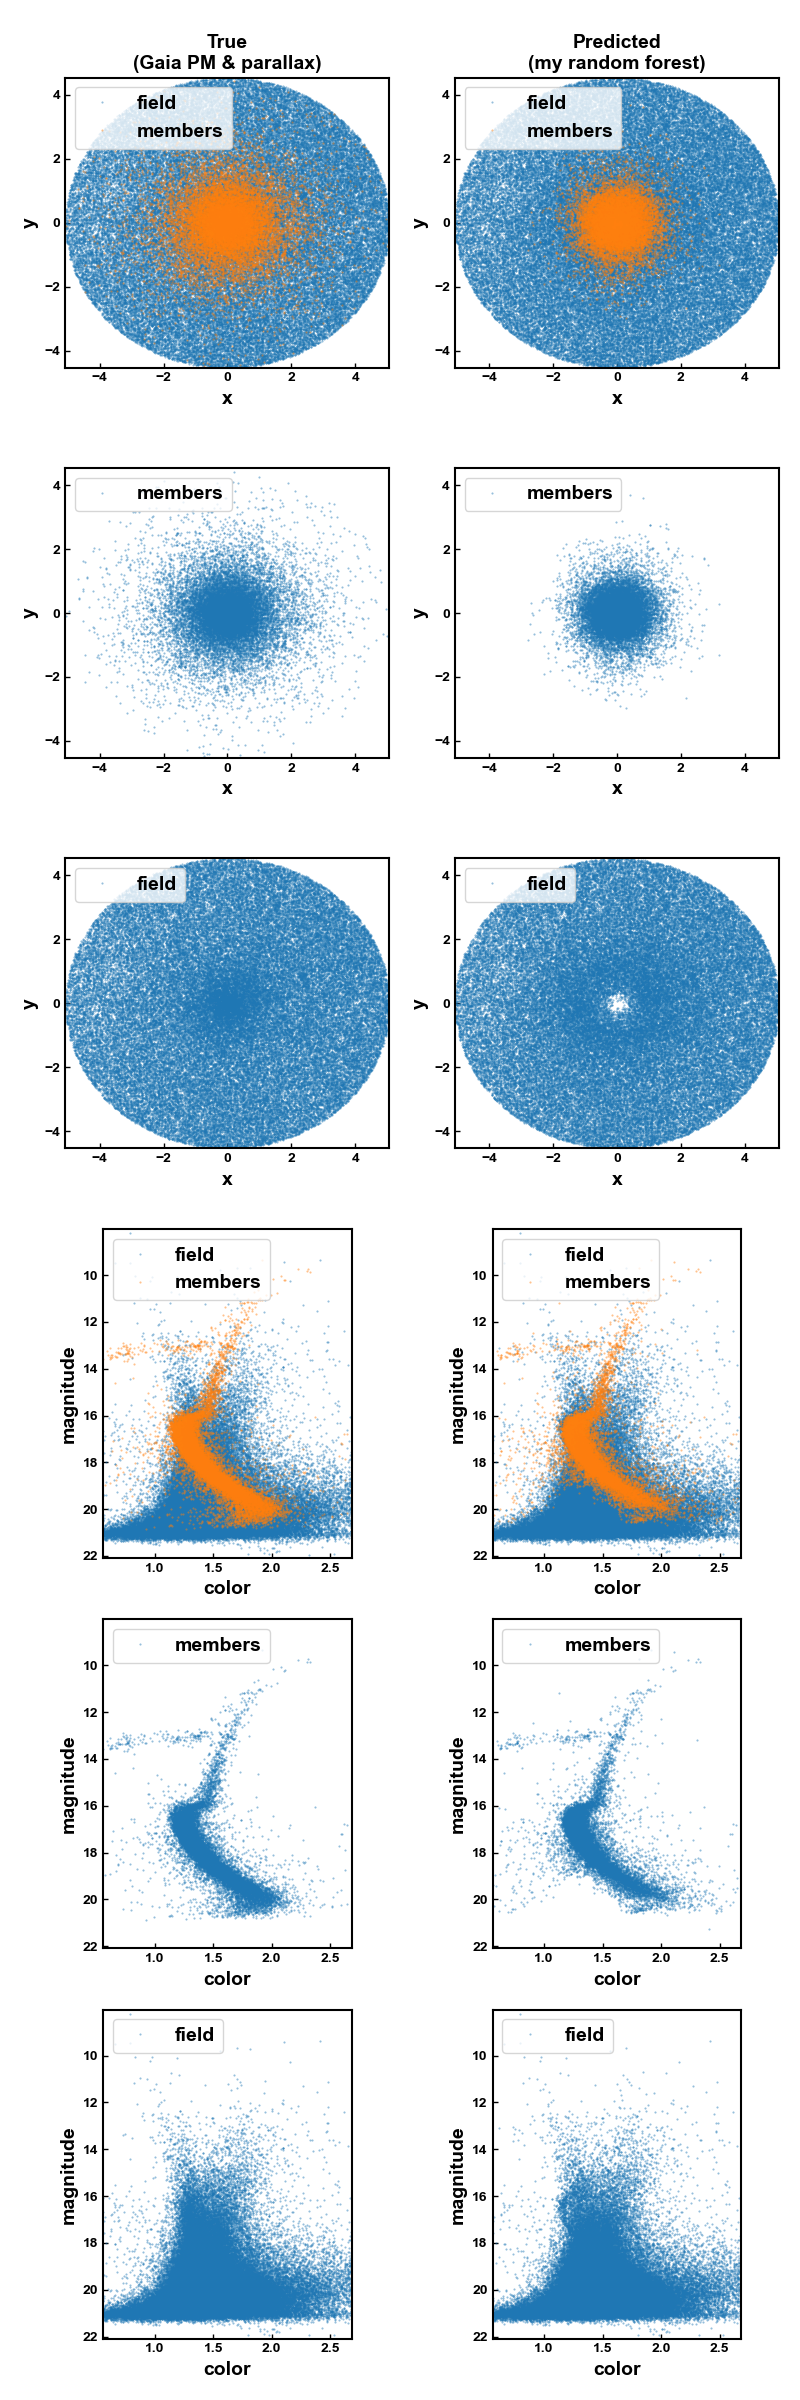

In [165]:
plt.close('all')
def myplot(row_number,set,xname,yname,pop,cmd=False,labels=True):
    if pop=='members':
        _pop=1
    elif pop=='field':
        _pop=0
    else:
        print("pop must be 'members' or 'field'")
    if labels:
        pass
    else:
        pop=''
    ax[row_number,0].plot(set[xname][y_real==_pop],set[yname][y_real==_pop],'.',alpha=0.5,ms=1,label=pop)
    ax[row_number,1].plot(set[xname][y_real_pred==_pop],set[yname][y_real_pred==_pop],'.',alpha=0.5,ms=1,label=pop)
    # ax[row_number,1].plot(set[xname][y_train_pred==_pop],set[yname][y_train_pred==_pop],'.',alpha=0.1,ms=1,label=pop)
    if not cmd:
        ax[row_number,0].set_xlim(set[xname].min(),set[xname].max())
        ax[row_number,0].set_ylim(set[yname].min(),set[yname].max())
        ax[row_number,1].set_xlim(set[xname].min(),set[xname].max())
        ax[row_number,1].set_ylim(set[yname].min(),set[yname].max())
    else:
        ax[row_number,0].set_xlim(np.percentile(set[xname],[1,99])) #.min(),strat_train_set[xname].max())
        ax[row_number,0].set_ylim(set[yname].max(),set[yname].min()) 
        ax[row_number,1].set_xlim(np.percentile(set[xname],[1,99])) #.min(),strat_train_set[xname].max())
        ax[row_number,1].set_ylim(set[yname].max(),set[yname].min()) 
    ax[row_number,0].set_xlabel(xname)
    ax[row_number,0].set_ylabel(yname)
    ax[row_number,1].set_xlabel(xname)
    ax[row_number,1].set_ylabel(yname)
    if labels:
        ax[row_number,0].legend(loc='upper left')
        ax[row_number,1].legend(loc='upper left')
    else:
        pass


nrows = 6
ncols = 2
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, layout=None,figsize=(8,24))

myplot(0,df,'x','y',pop='field')
myplot(0,df,'x','y',pop='members')
ax[0,0].set_aspect(1)
ax[0,1].set_aspect(1)
ax[0,0].set_title('True\n(Gaia PM & parallax)')
ax[0,1].set_title('Predicted\n(my random forest)')

myplot(1,df,'x','y',pop='members')
ax[1,0].set_aspect(1)
ax[1,1].set_aspect(1)
# ax[1,0].set_title('True')
# ax[1,1].set_title('Predicted')

myplot(2,df,'x','y',pop='field')
ax[2,0].set_aspect(1)
ax[2,1].set_aspect(1)

cmd_aspect = 0.2

myplot(3,df,'color','magnitude',pop='field',cmd=True)
myplot(3,df,'color','magnitude',pop='members',cmd=True)
ax[3,0].set_aspect(cmd_aspect)
ax[3,1].set_aspect(cmd_aspect)

myplot(4,df,'color','magnitude',pop='members',cmd=True)
ax[4,0].set_aspect(cmd_aspect)
ax[4,1].set_aspect(cmd_aspect)

myplot(5,df,'color','magnitude',pop='field',cmd=True)
ax[5,0].set_aspect(cmd_aspect)
ax[5,1].set_aspect(cmd_aspect)

fig.tight_layout()


In [171]:
plt.savefig('figures/m4_cleaned.png',bbox_inches='tight')

## Metrics

In [ ]:
#perfect lables do not touch
confusion_matrix(y_train,y_train_pred)

array([[60406,  3467],
       [ 3786, 13250]])

In [166]:
confusion_matrix(y_real,y_real_pred)

array([[67082,  3888],
       [ 6244, 12685]])

In [168]:
precision_score(y_real, y_real_pred)

0.765401556748929

In [169]:
recall_score(y_real, y_real_pred)

0.6701357705108564

In [170]:
f1_score(y_real, y_real_pred)

0.7146076277392823

In [187]:
from sklearn.metrics import ConfusionMatrixDisplay


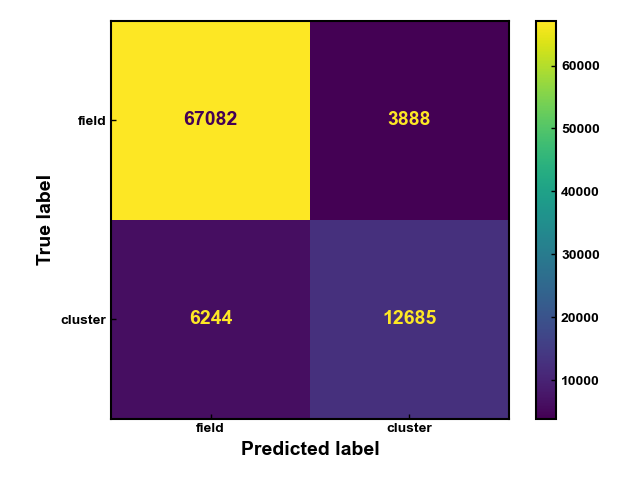

In [196]:
fig, ax = plt.subplots()
ConfusionMatrixDisplay.from_predictions(y_real, y_real_pred,ax=ax)
ax.xaxis.set_ticklabels(['field','cluster'])
ax.yaxis.set_ticklabels(['field','cluster'])
plt.tight_layout()

In [197]:
plt.savefig('figures/m4_confusion_matrix.png',bbox_inches='tight')